In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## DataLoad

In [2]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')
ds2 = fred.get_series('DGS2').fillna(method='pad')
tb3 = fred.get_series('DTB3').fillna(method='pad')
dff = fred.get_series('DFF').fillna(method='pad')

In [3]:
## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div']
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20
df_ref['DGS2'] = ds2
df_ref['DTB3'] = tb3

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, '^DJI', 'Div')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS2', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'DGS2', 'DTB3', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']]
_cols = ['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold']
df_ref[_cols] = df_ref[_cols]/df_ref[_cols].iloc[0]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']
df_ref['Cash'] = (df_ref['DTB3']/100 * 1/252 + 1).cumprod()

[*********************100%%**********************]  4 of 4 completed

0.918799498151725
0.8698779253276527
0.8863096696592956
1.0152920983995006
0.6626496911206705
0.7092700891822907
0.9953424146502148


In [4]:
## 프로젝트마다 필요한 데이터
tickers = ['SCHD', 'TLT', 'SGOV']
df_ori = data_funcs.get_merged_df(*tickers)
df_ori = df_ori[tickers]

[*********************100%%**********************]  3 of 3 completed


In [19]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = myfuncs.imputation(df_imp, 'Div', 'SCHD')
df_imp = myfuncs.imputation(df_imp, 'DGS20', 'TLT')
df_imp = myfuncs.imputation(df_imp, 'Cash', 'SGOV')

## 비보간 시계열 데이터
df_cut = df_imp["1999":]
df_cut = df_cut/df_cut.iloc[0]

0.9959929750700588
-0.30361094956148793
1.020374631755098


In [6]:
assets = ['SGOV', 'TLT', 'SCHD']
assets_sp = ['SGOV', 'TLT']

In [141]:
plot_df = df_imp.copy()
# plot_df = df_imp['1999':].copy()
# plot_df = df_cut[:]
plot_df = plot_df/plot_df.iloc[0]
highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

# highlight_periods = [
#                      (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
#                      (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
#                      (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

# highlight_periods = [(shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

In [117]:
import yfinance as yf

In [118]:
tickers = ["SGOV"]
## 데이터 다운로드
df_ori = yf.download(tickers, ignore_tz = True, auto_adjust=False)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
mycolors['color_norm'], 

In [169]:
def trend_plot(df, assets, highlight_periods=highlight_periods, colors=None, title=True):
    """
    Plots a cumulative return graph for given assets.

    Parameters:
        df (DataFrame): A DataFrame containing date-indexed asset data.
        assets (list): List of asset column names to include in the plot.
        highlight_periods (list of tuples): List of (start_date, end_date) tuples to highlight on the graph.
        colors (list): List of colors for the lines, must match the number of assets.
    """
    data = df[assets].copy()
    _df = data.reset_index()
    _df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

    # Use provided colors or default palette
    if colors is None:
        colors = sns.color_palette('tab10', len(assets))

    lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2)
    if title:
        plt.title(f'Trends of {", ".join(assets)} ({data.index[0].year}~{data.index[-1].year})', fontsize=22, fontweight='bold')
    else:
        pass
    plt.ylabel(f"Rate(%)", fontsize=14, labelpad=-50, loc="top", rotation=0, color=mycolors['color_around'])
    plt.xlabel("Date", fontsize=14, color=mycolors['color_around'])
    plt.xticks(fontsize=12, color=mycolors['color_around'])
    plt.yticks(fontsize=12, color=mycolors['color_around'])

    # Adjust tick params
    plt.gca().tick_params(axis="y", pad=1)

    # Set y-axis to logarithmic scale
    ## plt.yscale('log')

    # Add grid
    plt.grid(color=mycolors["color_around2"], linestyle="--", linewidth=0.7, alpha=0.7)

    x_min, x_max = data.index.min(), data.index.max()

    # Highlight periods if provided
    if highlight_periods:
        for start, end in highlight_periods:
            start_date = pd.to_datetime(start)
            end_date = pd.to_datetime(end)

            # Adjust highlight periods to fit within the x-axis range
            if start_date > x_max or end_date < x_min:
                continue
            adjusted_start = max(start_date, x_min)
            adjusted_end = min(end_date, x_max)
            plt.axvspan(adjusted_start, adjusted_end, facecolor=mycolors['color_around'], alpha=0.30)

    # Convert x-axis to numeric format
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{round(y, 1)}'))

    # Show the plot
    plt.tight_layout()
    plt.show()

In [170]:
# trend_plot((df_ori[['Close', 'Adj Close']]/df_ori[['Close', 'Adj Close']].iloc[0]*100).rename(columns={'Close':'SGOV', 'Adj Close':'SGOV(TR)'}),
#            ['SGOV'],
#               highlight_periods=highlight_periods, colors=[mycolors['color_cont'], mycolors['color_norm'], ])

In [171]:
# trend_plot((df_ori[['Close', 'Adj Close']]/df_ori[['Close', 'Adj Close']].iloc[0]*100).rename(columns={'Close':'SGOV', 'Adj Close':'SGOV(TR)'}), ['SGOV', 'SGOV(TR)'],
#               highlight_periods=highlight_periods, colors=[mycolors['color_cont'], mycolors['color_norm'], ])

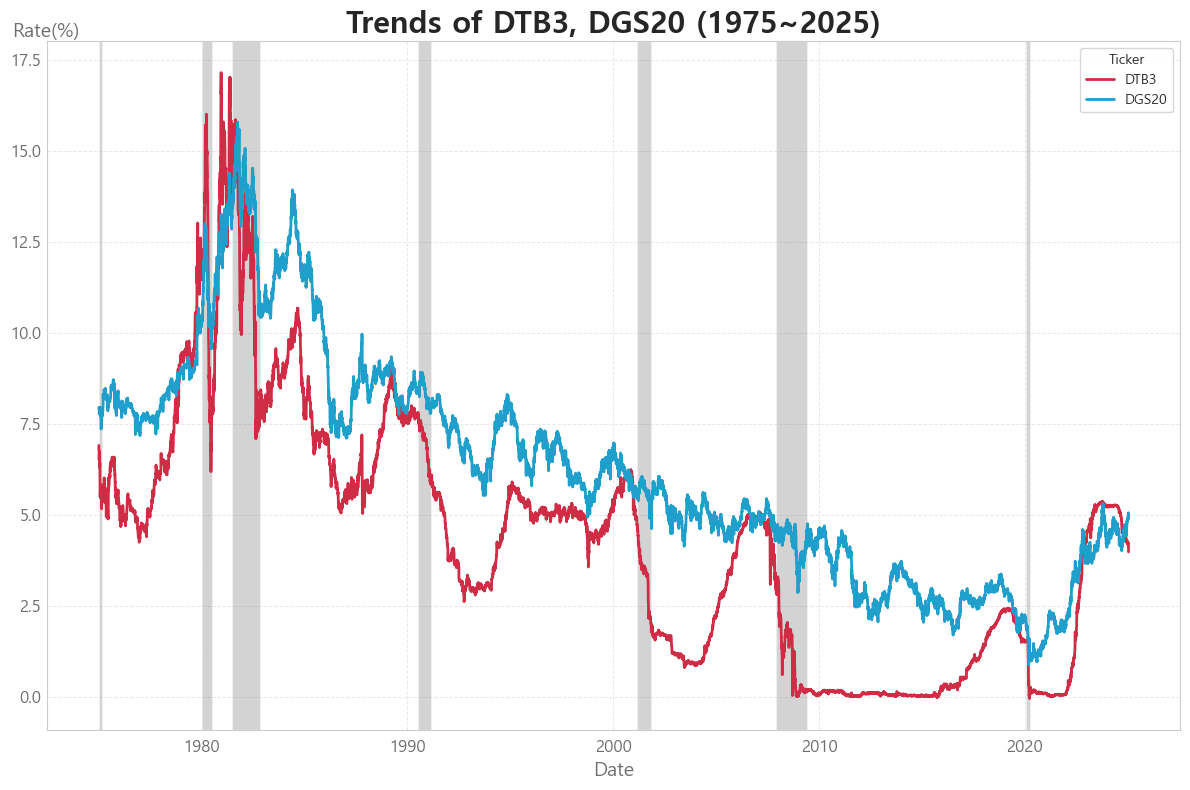

In [172]:
trend_plot(df_ref, ['DTB3', 'DGS20'], colors=[mycolors['color_norm'], mycolors['color_cont']])

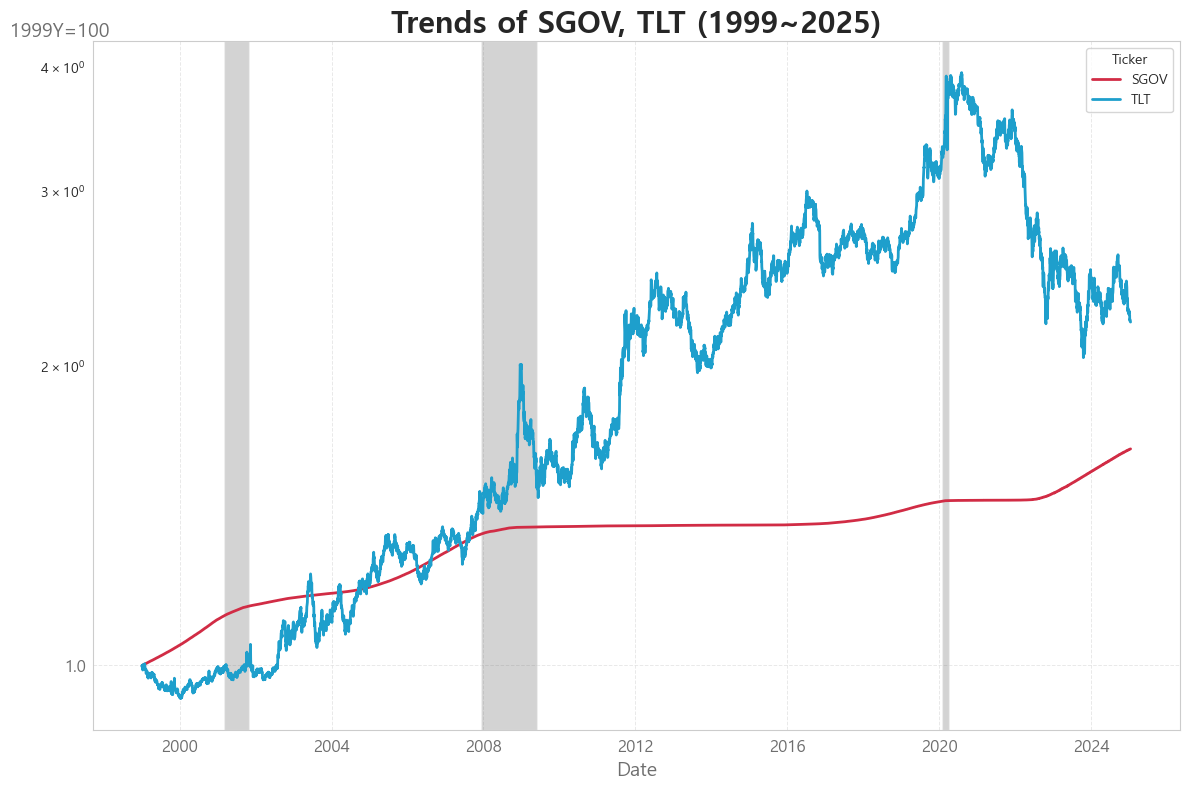

In [116]:
gm.trend_plot(plot_df, ['SGOV', 'TLT'], highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont']])

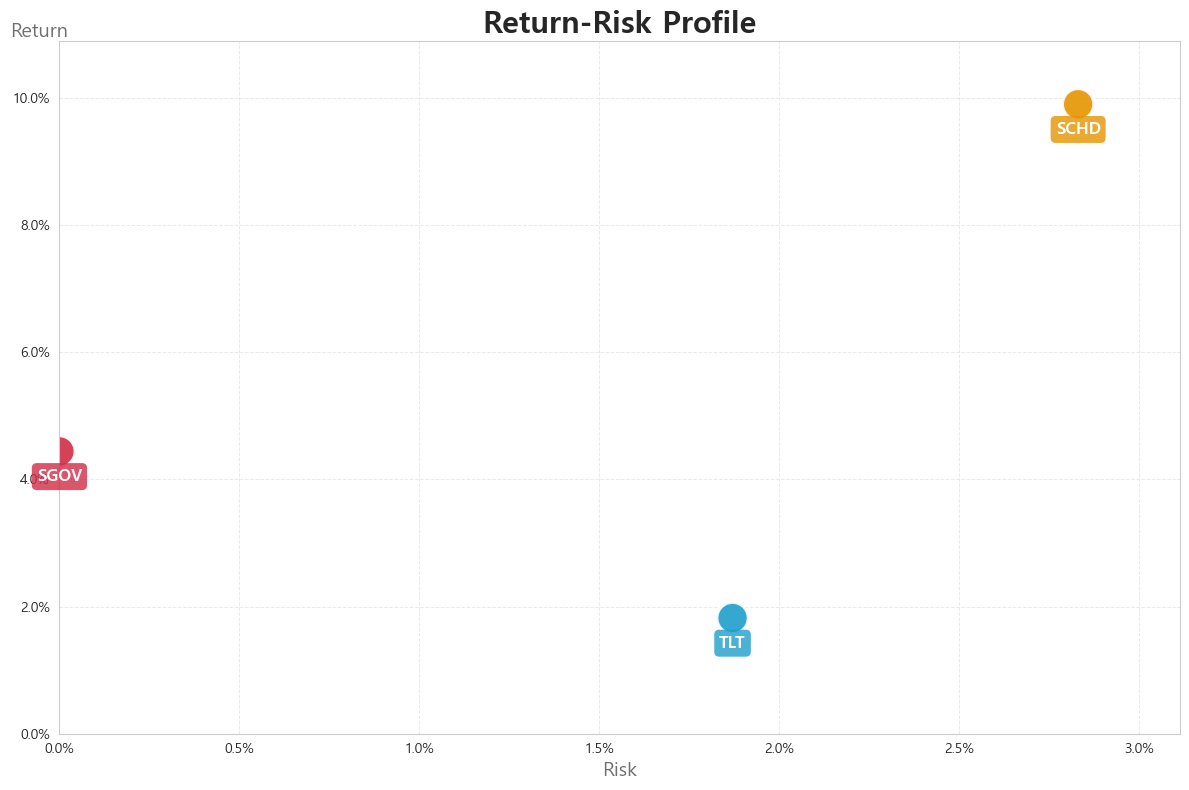

In [13]:
return_risk_df = anal_funcs.get_Vol_report(plot_df[assets], method='a', rf=0)
# gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])
gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

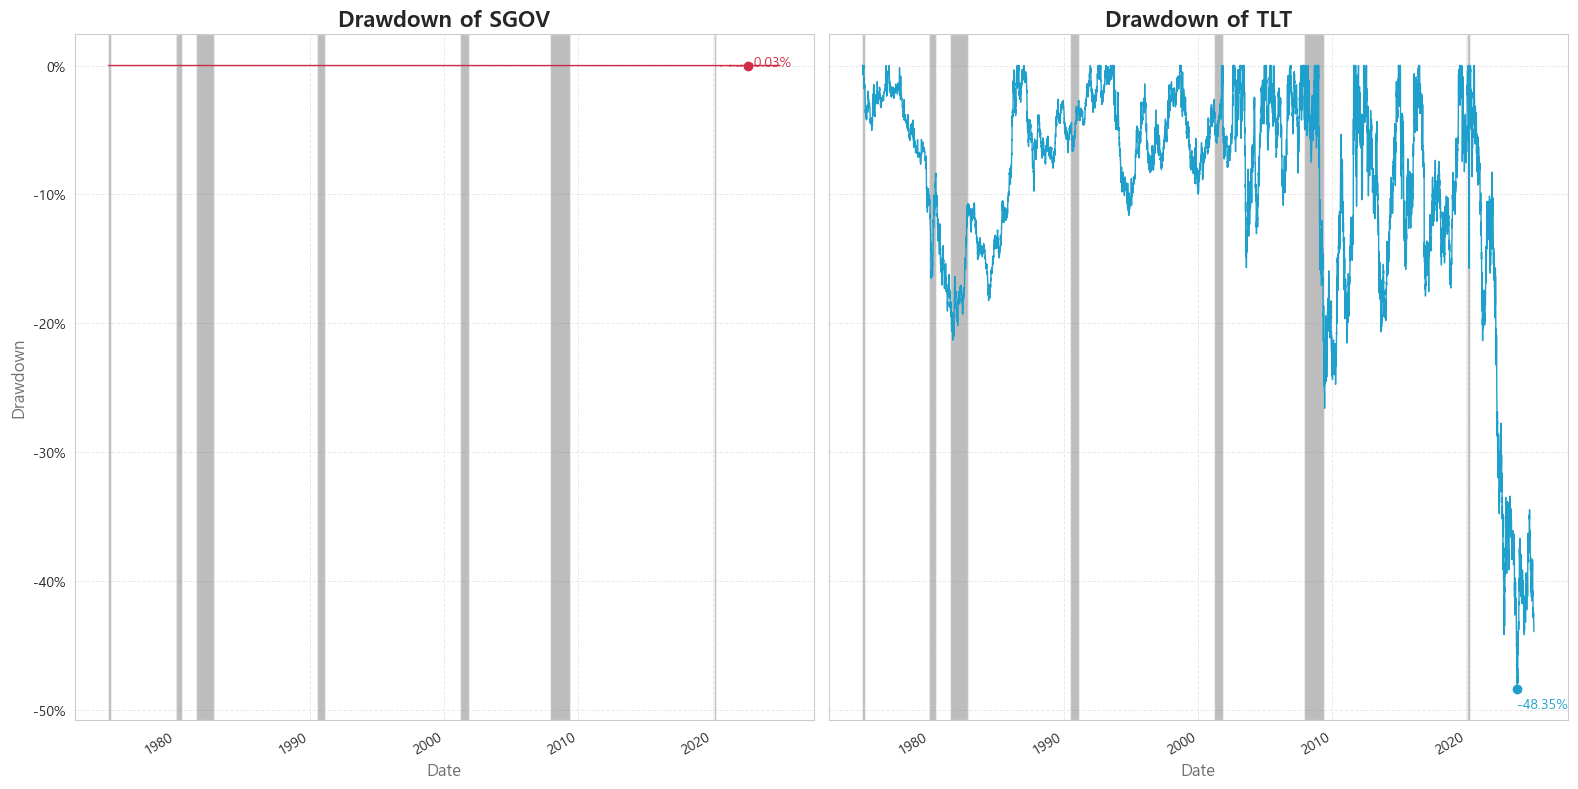

In [142]:
gm.drawdown_plot(plot_df, assets_sp, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']], highlight_periods=highlight_periods)

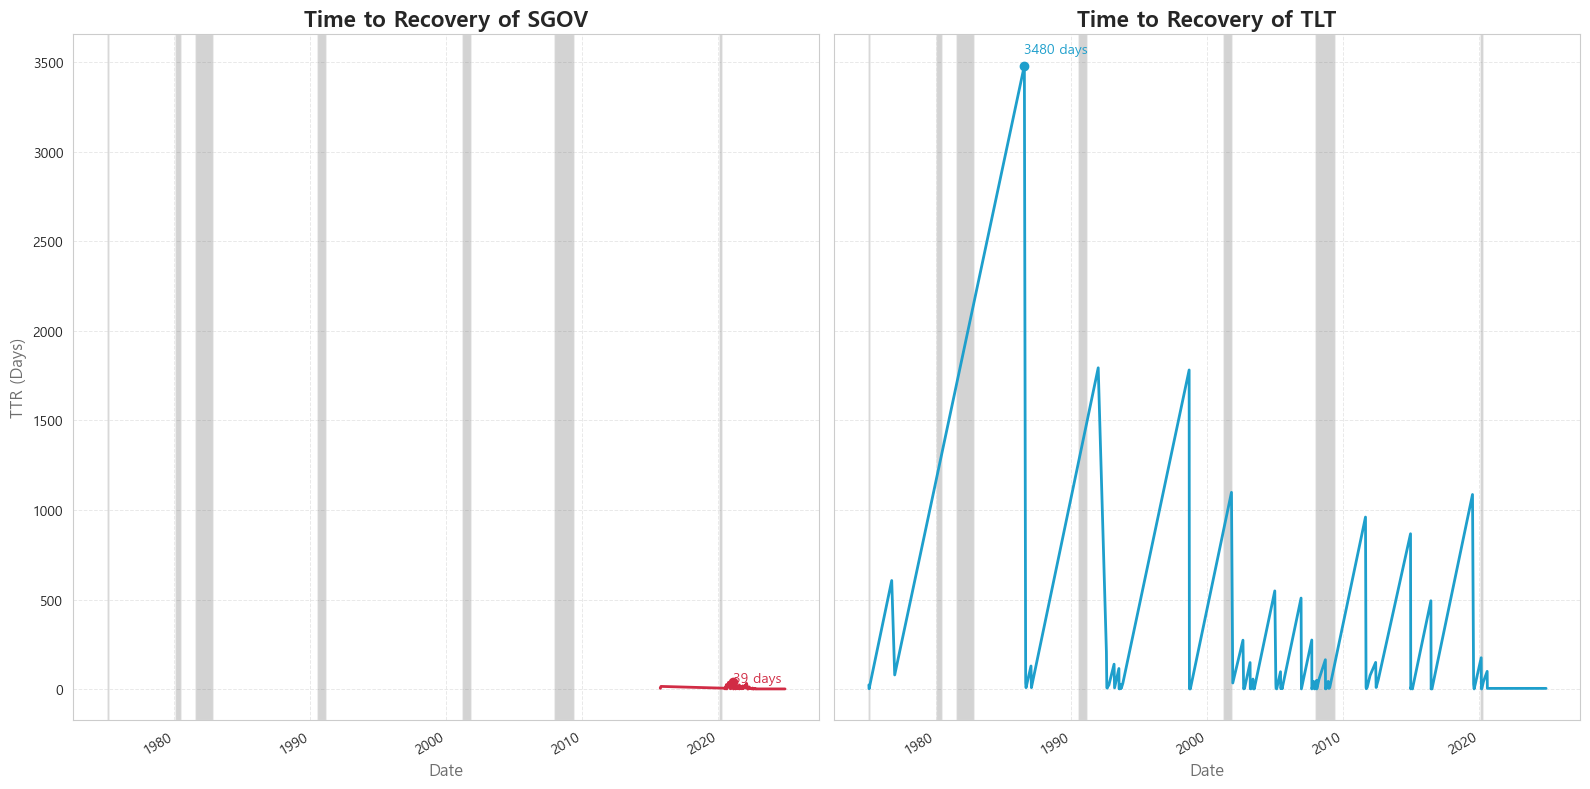

In [143]:
ttr_df = myfuncs.get_ttr_df(plot_df, assets)

gm.ttr_plot(ttr_df, assets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

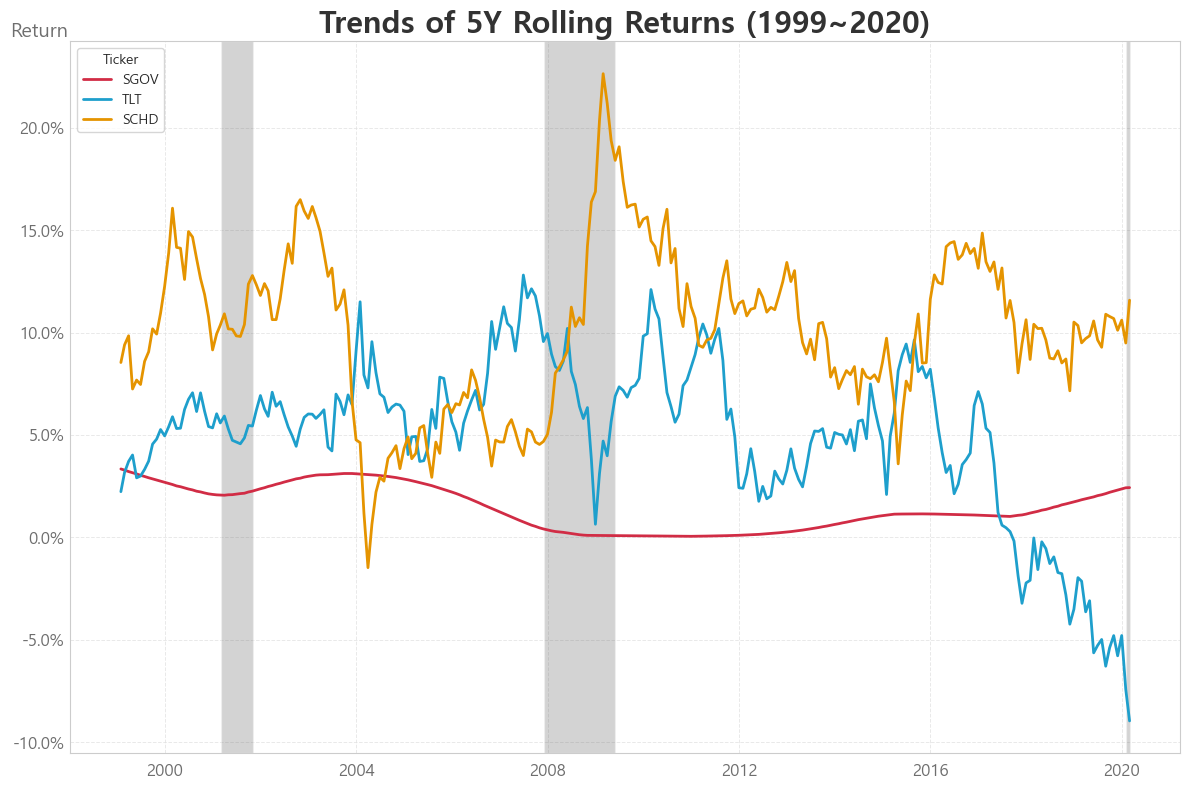

In [60]:
rr_df = myfuncs.get_rr_df(plot_df, assets)
gm.rr_trend_plot(rr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

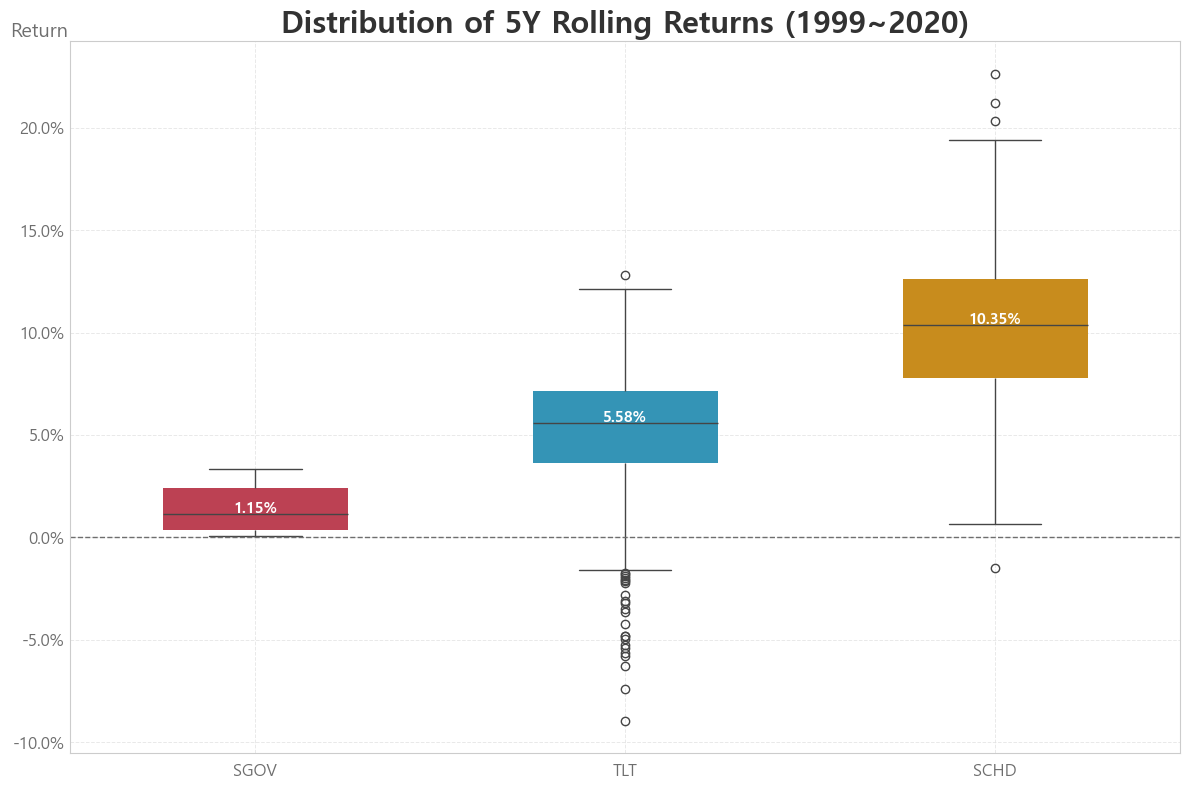

In [61]:
gm.rr_box_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

## Optimization

In [27]:
assets_port = assets + ['Gold']

In [28]:
corr_df = plot_df.pct_change()[assets_port].corr()

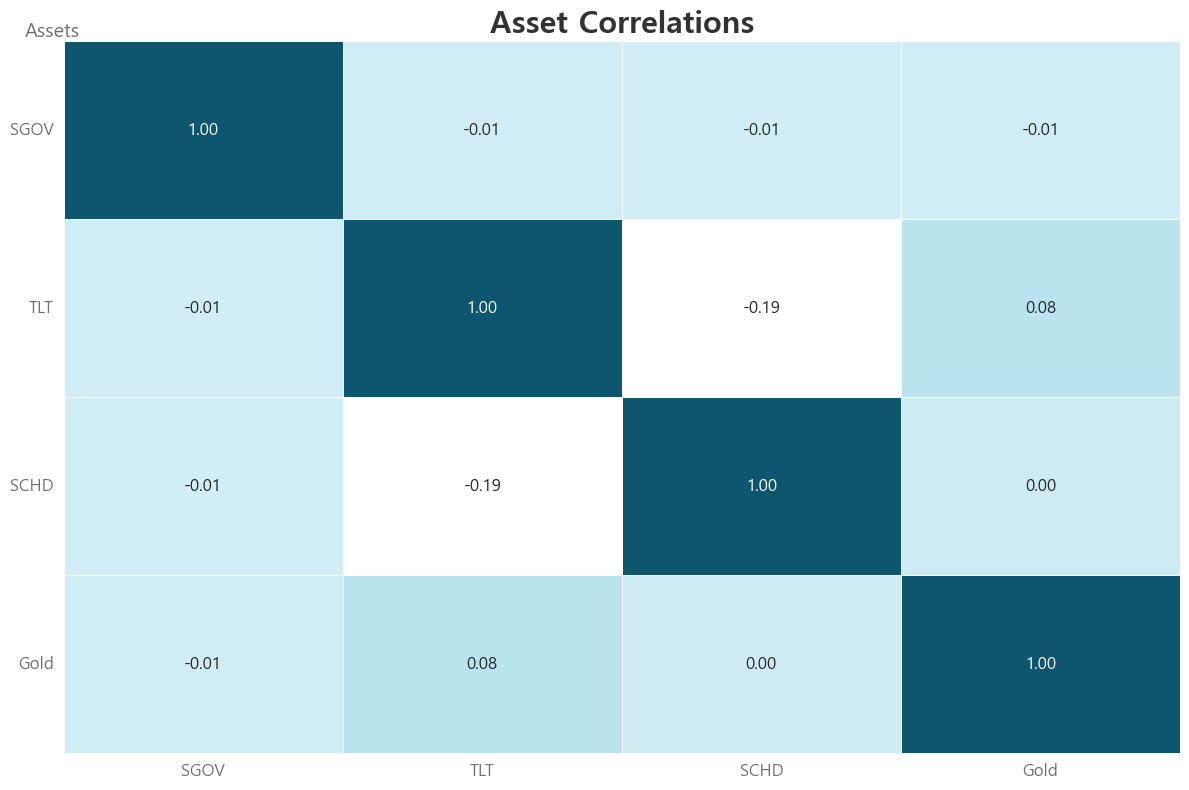

In [29]:
gm.corr_plot(corr_df, cmap=custom_cmap)

In [88]:
# plot_df = df_imp.copy()
plot_df = df_imp['1999':].copy()
plot_df = plot_df/plot_df.iloc[0]

In [79]:
df_imp_m = plot_df[assets_port].resample('M').last()

In [80]:
allocator = portfolio_obtimizer.PortfolioAllocator()

# process, obtimal, min_risk = allocator.cal_optimal(df_imp_m, unit='monthly', rebalancing='m', d=10, min_edge=0)
# gm.portfilio_return_risk_profile_plot(process, min_risk, min_risk, cmap=custom_cmap)

cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)
eg. process, obtimal, min_risk = cal_optimal(df)


In [81]:
bm_ratios = {'9:1(TLT)': [0, 0.1, 0.9, 0], '4:6(TLT)': [0, 0.6, 0.4, 0],
             '8:2(TLT)': [0, 0.2, 0.8, 0], '3:7(TLT)': [0, 0.7, 0.3, 0],
             '7:3(TLT)': [0, 0.3, 0.7, 0], '2:8(TLT)': [0, 0.8, 0.2, 0],
             '6:4(TLT)': [0, 0.4, 0.6, 0], '1:9(TLT)': [0, 0.9, 0.1, 0],
             '5:5(TLT)': [0, 0.5, 0.5, 0],

             '9:1(SGOV)': [0.1, 0, 0.9, 0], '4:6(SGOV)': [0.6, 0, 0.4, 0],
             '8:2(SGOV)': [0.2, 0, 0.8, 0], '3:7(SGOV)': [0.7, 0, 0.3, 0],
             '7:3(SGOV)': [0.3, 0, 0.7, 0], '2:8(SGOV)': [0.8, 0, 0.2, 0],
             '6:4(SGOV)': [0.4, 0, 0.6, 0], '1:9(SGOV)': [0.9, 0, 0.1, 0],
             '5:5(SGOV)': [0.5, 0, 0.5, 0],}


ls = {}
for _key in bm_ratios.keys():
    ratio = bm_ratios[_key]
    result = allocator.cal_rebalancing(df_imp_m[df_imp_m.columns], ratio=ratio, rebalancing='m', unit='monthly')
    result.rename(columns={'strategy':'Portfolio'}, inplace=True)
    result = result/result.iloc[0]*100
    ls[_key] = result['Portfolio']

In [86]:
def return_risk_profile_plot(df, assets, target_col='Return', risk_col='Volatility(Down)', colors=None, title=True):
    """
    Enhanced Return vs Downside Risk plot with improved design and annotations.
    """
    data = df[[target_col, risk_col]].copy()
    data.index = assets  # Set index as asset names

    # Calculate Sortino Ratios
    data['Sortino Ratio'] = data[target_col] / data[risk_col]

    # Use provided colors or default palette
    if colors is None:
        colors = sns.color_palette('tab10', len(assets))

    # Graph settings
    plt.figure(figsize=figsize)
    sizes = 500

    x = data[risk_col]
    y = data[target_col]
    labels = data.index

    scatter = plt.scatter(x, y, c=colors, s=sizes, edgecolors="white", linewidth=2, alpha=0.9)

    # Add labels
    for i, label in enumerate(labels):
        if (i >= 18) | (i == 8) | (i == 17):
            plt.text(
                x[i], y[i] - abs(y.max()) * 0.04, label, fontsize=12, ha="center", va="center", 
                color="white", fontweight="bold", bbox=dict(facecolor=colors[i], edgecolor='none', alpha=0.8, boxstyle="round,pad=0.3")
            )

    # Axis formatters
    def percent_formatter(x, pos):
        return f"{round(x, 1)}%"

    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(percent_formatter))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(percent_formatter))

    # Axis settings
    if title:
        plt.title(f"Return-Risk Profile", fontsize=22, fontweight="bold")
    else:
        pass
    plt.xlabel("Risk", fontsize=14, color=mycolors['color_around'])
    plt.ylabel("Return", fontsize=14, labelpad=-40, color=mycolors['color_around'], loc="top", rotation=0)
    plt.grid(color=mycolors["color_around2"], linestyle="--", linewidth=0.7, alpha=0.7)
    plt.xlim(-0.3, x.max() * 1.1)
    plt.ylim(0, y.max() * 1.1)

    # Layout adjustments
    plt.tight_layout()
    plt.show()

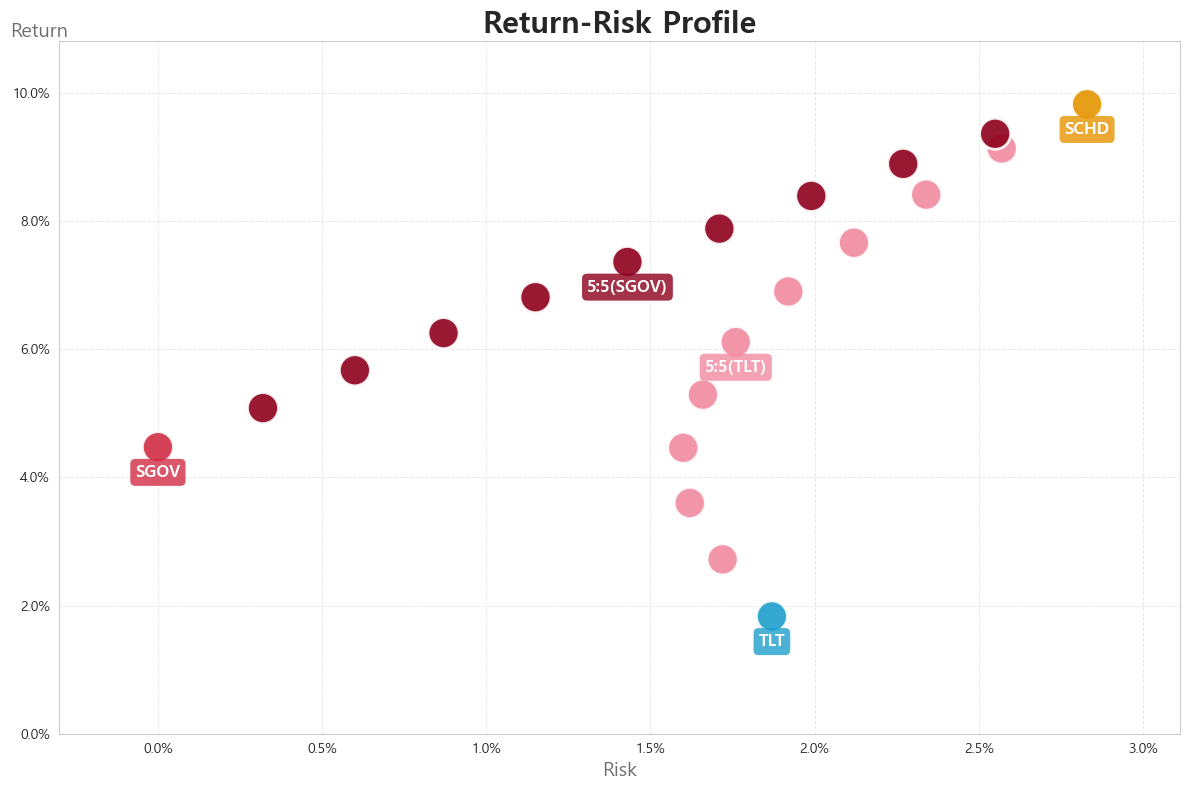

In [87]:
rr_res = pd.DataFrame(ls)
rr_res['SGOV'] = result['SGOV']
rr_res['TLT'] = result['TLT']
rr_res['SCHD'] = result['SCHD']


return_risk_df = anal_funcs.get_Vol_report(rr_res, unit='monthly', method='a', rf=0)

return_risk_profile_plot(
    return_risk_df,
    list(return_risk_df.index),
    colors=[
        mycolors["color_norm3"],
        mycolors["color_norm3"],
        mycolors["color_norm3"],
        mycolors["color_norm3"],
        mycolors["color_norm3"],
        mycolors["color_norm3"],
        mycolors["color_norm3"],
        mycolors["color_norm3"],
        mycolors["color_norm3"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm2"],
        mycolors["color_norm"],
        mycolors["color_cont"],
        mycolors["color_sub"],
    ],
)

In [103]:
## ratio 임의 조정시
ratio = [0.5, 0.0, 0.5, 0.0]
res_sgov = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing='m', unit='daily')
res_sgov.rename(columns={'strategy':'SCHD+SGOV'}, inplace=True)
res_sgov = res_sgov/res_sgov.iloc[0]*100

## ratio 임의 조정시
ratio = [0.5, 0.5, 0.0, 0.0]
res_tlt = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing='m', unit='daily')
res_tlt.rename(columns={'strategy':'SCHD+TLT'}, inplace=True)
res_tlt = res_tlt/res_tlt.iloc[0]*100

In [104]:
result = res_sgov[['SCHD', 'SCHD+SGOV']]
result['SCHD+TLT'] = res_tlt['SCHD+TLT']

In [105]:
port_assets_sp = ['SCHD+SGOV', 'SCHD+TLT']

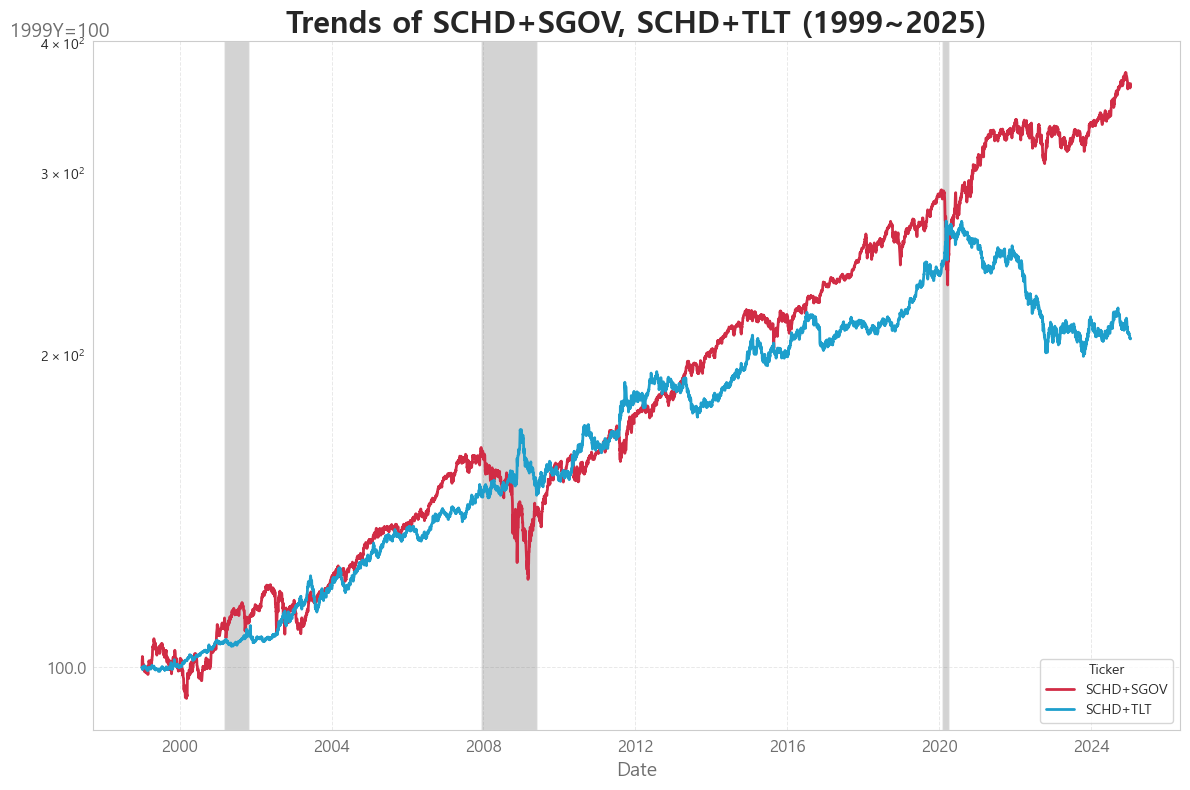

In [114]:
gm.trend_plot(result, port_assets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

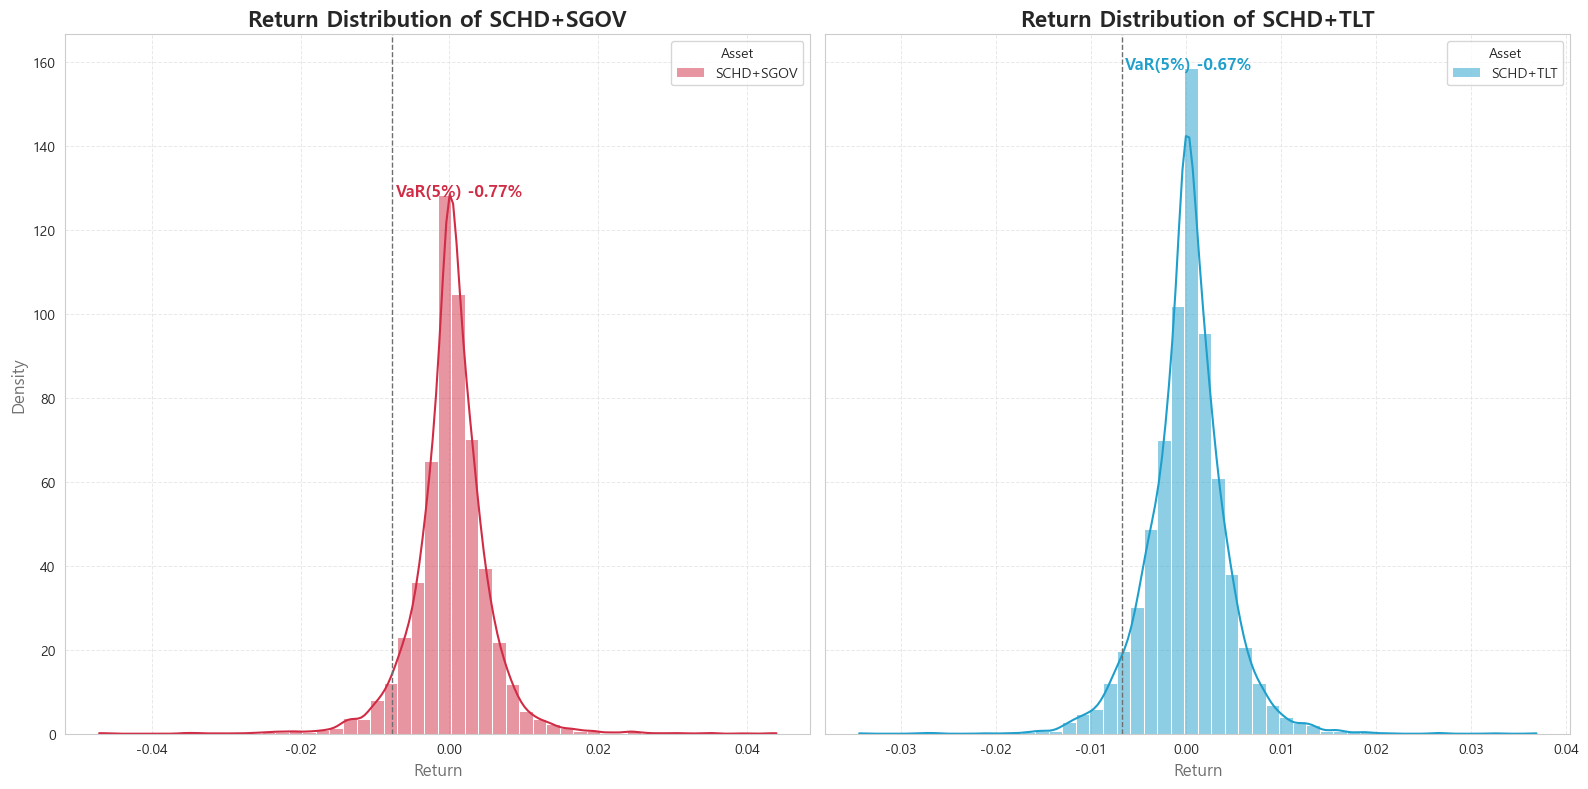

In [107]:
gm.asset_histogram_plot(result.pct_change(), port_assets_sp, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

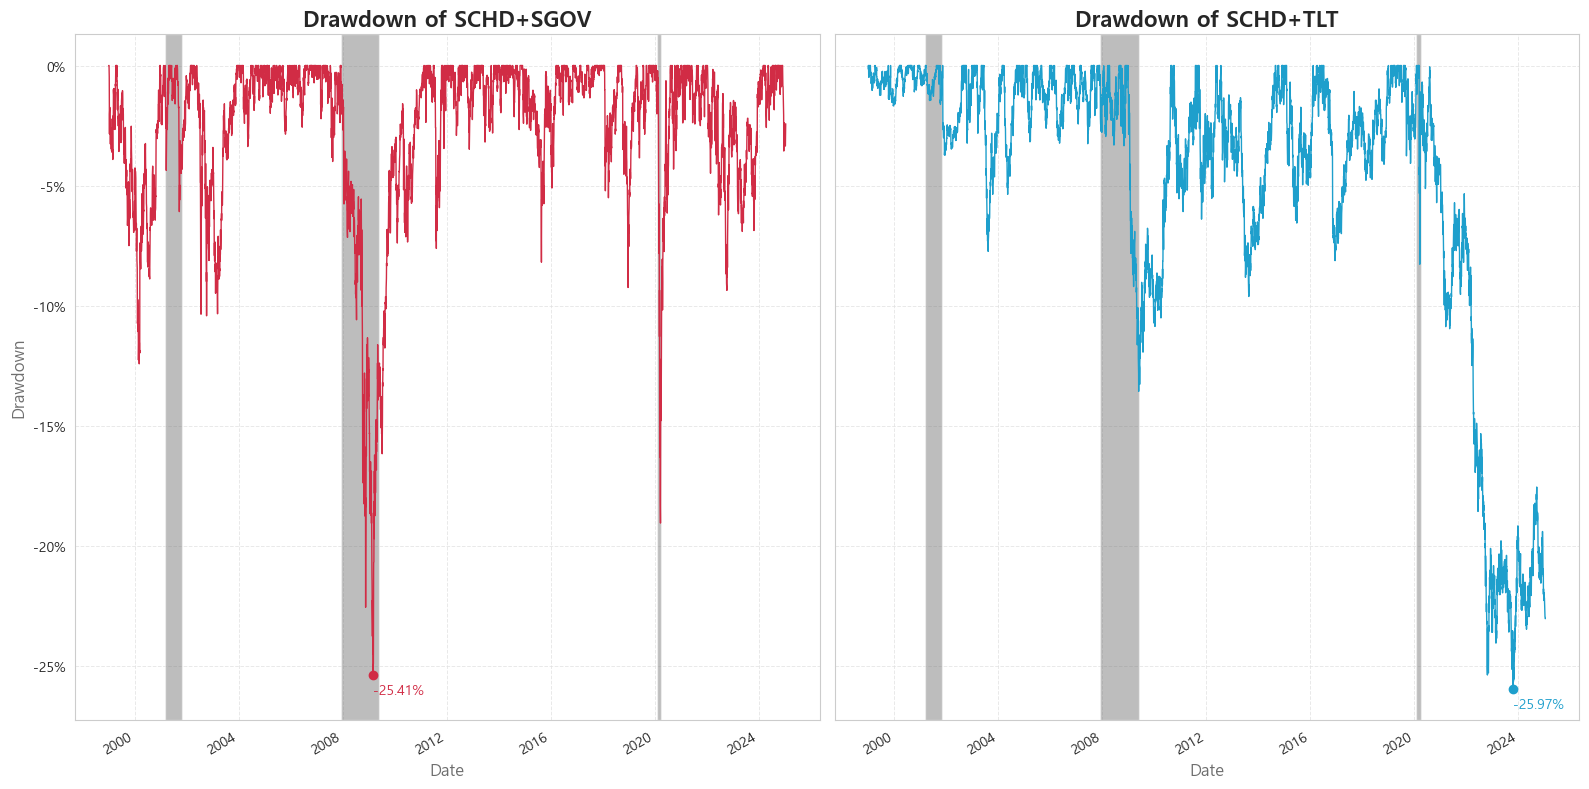

In [108]:
gm.drawdown_plot(result, port_assets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

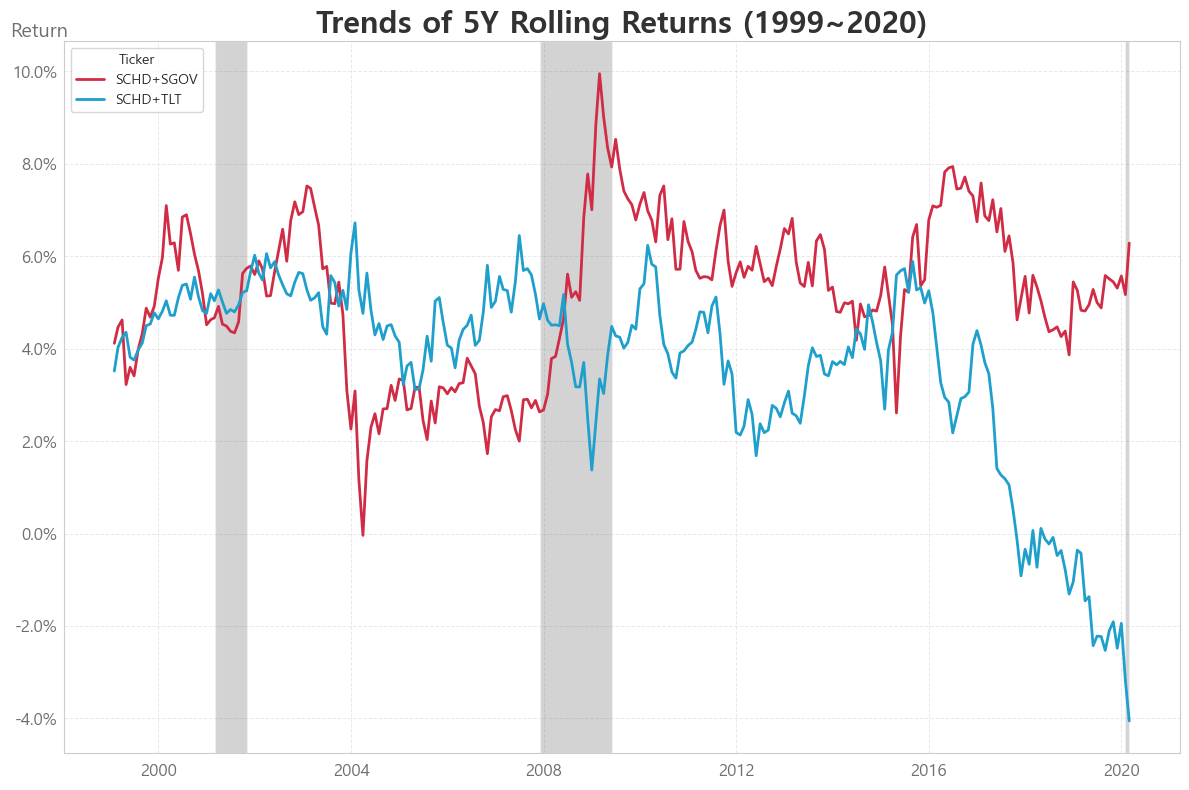

In [110]:
rr_df = myfuncs.get_rr_df(result, port_assets_sp)
gm.rr_trend_plot(rr_df, port_assets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont']])